# DFT

DFT(Discrete Fourier Transform)，离散傅里叶变化，可以将离散信号变换到频域，它的公式非常简单:

$$
X[k] = \sum_{n=0}^{N-1} x[n] e^{-j2\pi kn/N}
$$

$X[k]$：离散频率下标为k时的频率大小

$x[n]$: 离散时域信号序列

$N$: 信号序列的长度，也就是采样的个数

如果你刚接触DFT，并且之前没有信号处理的相关经验，那么第一次看到这个公式，你可能有一些疑惑，为什么这个公式就能进行时域与频域之间的转换呢？
这里，我不打算去解释它，因为我水平有限，说的不清楚。相反，在这里我想介绍，作为一个程序员，如何如实现DFT

# 从矩阵的角度看DFT

DFT的公式，虽然简单，但是理解起来比较麻烦，我发现如果用矩阵相乘的角度来理解上面的公式，就会非常简单，直接上矩阵：
$$
\begin{bmatrix}
s_0^0 & s_0^1 & \cdots & s_0^{N-1} \\
\vdots & \vdots  & \vdots &  \vdots\\
s_k^0 & s_k^1 & \cdots & s_k^{N-1} \\
\vdots & \vdots  & \ddots &  \vdots\\
s_{N-1}^0 & s_{N-1}^1 & \cdots & s_{N-1}^{N-1} \\
\end{bmatrix}
\begin{bmatrix}
x[0] \\
x[1] \\
\vdots\\
x[n] \\
\vdots \\
x[N-1]
\end{bmatrix} = \begin{bmatrix}
X[0] \\
X[1] \\
\vdots\\
X[k] \\
\vdots \\
X[N-1]
\end{bmatrix}
$$

$S$矩阵中的每一行都是一个$S_k$向量，$S_k = e^{-j2\pi kn/N}, n=0,1,\cdots,N-1$，进一步简化上面的表示，得到：
$$
\begin{bmatrix}
\cdots & S_0 & \cdots \\
       & \vdots &     \\
\cdots & S_k & \cdots \\
       & \vdots &     \\
\cdots & S_{N-1} & \cdots \\
\end{bmatrix}
\begin{bmatrix}
x[0] \\
x[1] \\
\vdots\\
x[n] \\
\vdots \\
x[N-1]
\end{bmatrix} = \begin{bmatrix}
X[0] \\
X[1] \\
\vdots\\
X[k] \\
\vdots \\
X[N-1]
\end{bmatrix}
$$

OK，通过上面的表示，我们很容易将DFT理解成为一种矩阵相乘的操作，这对于我们编码是很容易的。

# IDFT
IDFT(Inverse Discrete Fourier Transform), 傅里叶逆变换，可以将频域信号转换到时域中

# Talk is cheap, show me the code

根据上面的理解，我们只需要构建出$S$矩阵，然后做矩阵相乘，就等得到DFT的结果

在这之前，我们先介绍如何生成正弦信号，以及如何用scipy中的fft模块进行DFT操作，以验证我们的结果是否正确

## 正弦信号
$$
x[n] = A\cos(2\pi fnT + \phi)
$$

A: 幅度

f: 信号频率

n: 时间下标

T: 采样间隔, 等于 1/fs，fs为采样频率

$\phi$: 相位

下面介绍如何生成正弦信号

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

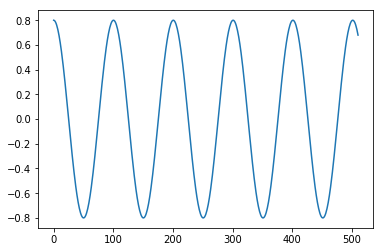

In [2]:
def generate_sinusoid(N, A, f0, fs, phi):
    '''
    N(int) : number of samples
    A(float) : amplitude
    f0(float): frequency in Hz
    fs(float): sample rate
    phi(float): initial phase
    
    return 
    x (numpy array): sinusoid signal which lenght is M
    '''
    
    T = 1/fs
    n = np.arange(N)    # [0,1,..., N-1]
    x = A * np.cos( 2*f0*np.pi*n*T + phi )
    
    return x

N = 511
A = 0.8
f0 = 440
fs = 44100
phi = 0

x = generate_sinusoid(N, A, f0, fs, phi)

plt.plot(x)
plt.show()

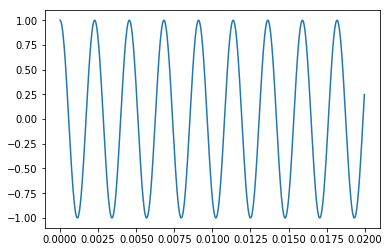

In [3]:
# 另一种生成正弦信号的方法，生成时长为t的序列
def generate_sinusoid_2(t, A, f0, fs, phi):
    '''
    t  (float) : 生成序列的时长
    A  (float) : amplitude
    f0 (float) : frequency
    fs (float) : sample rate
    phi(float) : initial phase
    
    returns
    x (numpy array): sinusoid signal sequence
    '''
    
    T = 1.0/fs
    N = t / T
    
    return generate_sinusoid(N, A, f0, fs, phi)

A = 1.0
f0 = 440
fs = 44100
phi = 0
t = 0.02

x = generate_sinusoid_2(t, A, f0, fs, phi)

n = np.arange(0, 0.02, 1/fs)
plt.plot(n, x)


## Scipy FFT

介绍如何Scipy的FFT模块计算DFT

注意，理论上输入信号的长度必须是$2^n$才能做FFT，而scipy中FFT却没有这样的限制

这是因为当长度不等于$2^n$时，scipy fft默认做DFT

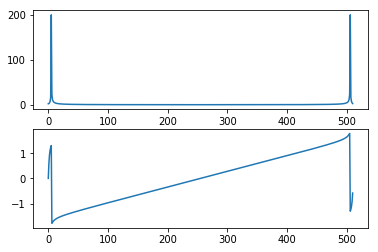

In [4]:
from scipy.fftpack import fft

# generate sinusoid
N = 511
A = 0.8
f0 = 440
fs = 44100
phi = 1.0
x = generate_sinusoid(N, A, f0, fs, phi)

# fft is
X = fft(x)
mX = np.abs(X)   # magnitude
pX = np.angle(X) # phase

# plot the magnitude and phase
plt.subplot(2,1,1)
plt.plot(mX)

plt.subplot(2,1,2)
plt.plot(pX)
plt.show()

## 自己实现DFT

自己实现DFT的关键就是构造出$S$，有两种方式：

+ 我们可以单独构建一个$S_k$，然后计算 $sum(S_k * x[n])$，得到 $X[k]$
+ 或者，构建整个矩阵$S$，一次性计算 $S*x[n]$，得到$X$

In [5]:
def generate_complex_sinusoid(k, N):
    '''
    k (int): frequency index
    N (int): length of complex sinusoid in samples
    
    returns
    c_sin (numpy array): the generated complex sinusoid (length N)
    '''
    
    n = np.arange(N)
    
    c_sin = np.exp(1j * 2 * np.pi * k * n / N)
    
    return np.conjugate(c_sin)

def generate_complex_sinusoid_matrix(N):
    '''
    N (int): length of complex sinusoid in samples
    
    returns
    c_sin_matrix (numpy array): the generated complex sinusoid (length N)
    '''
    
    n = np.arange(N)
    n = np.expand_dims(n, axis=1)      # 扩充维度，将1D向量，转为2D矩阵，方便后面的矩阵相乘
    
    k = n
    
    m = n.T * k / N                    # [N,1] * [1, N] = [N,N]
    
    S = np.exp(1j * 2 * np.pi * m)     # 计算矩阵 S
    
    return np.conjugate(S)

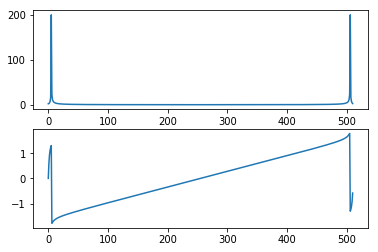

In [9]:
# 生成信号，用于测试
N = 511
A = 0.8
f0 = 440
fs = 44100
phi = 1.0
x = generate_sinusoid(N, A, f0, fs, phi)

# 第一种方式计算DFT
X_1 = np.array([])
for k in range(N):
    s = generate_complex_sinusoid(k, N)
    X_1 = np.append(X_1, np.sum(x * s))
    
mX = np.abs(X_1)
pX = np.angle(X_1)

# plot the magnitude and phase
plt.subplot(2,1,1)
plt.plot(mX)

plt.subplot(2,1,2)
plt.plot(pX)
plt.show()

# 结果和scipy的结果基本相同

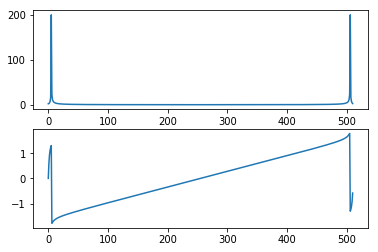

In [10]:
# 第二种方法计算DFT
S = generate_complex_sinusoid_matrix(N)
X_2 = np.dot(S, x)

mX = np.abs(X_2)
pX = np.angle(X_2)

# plot the magnitude and phase
plt.subplot(2,1,1)
plt.plot(mX)

plt.subplot(2,1,2)
plt.plot(pX)
plt.show()

# 总结

+ 回顾了DFT的计算公式，并尝试用矩阵相乘的角度来理解DFT
+ 介绍了两种生成正弦信号的方法
+ 实现了两种DFT的计算方法
+ 完整代码在[这里](https://github.com/jiemojiemo/audio_signal_processing_demo)